<a href="https://colab.research.google.com/github/ItaiKaplan/Machine-Learning-Assignments/blob/main/Logistic_Regression%2C_Bayes_and_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: 208524173_ 205411739

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [ ]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

# New Section

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

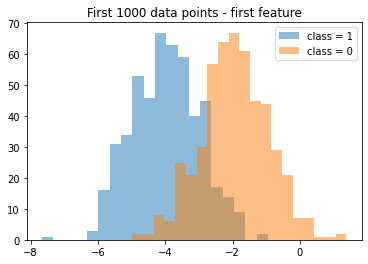

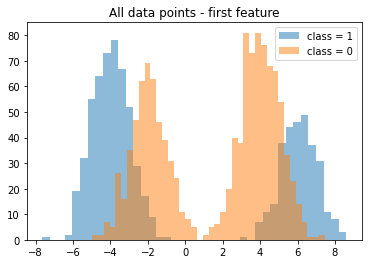

In [ ]:
training_set_numpy = training_set.to_numpy()

class_data_1_first1000 = training_set_numpy[np.where(training_set_numpy[ :1000, -1] == 1)]
class_data_0_first1000 = training_set_numpy[np.where(training_set_numpy[ :1000, -1] == 0)]

class_data_1_all = training_set_numpy[np.where(training_set_numpy[:, -1] == 1)]
class_data_0_all = training_set_numpy[np.where(training_set_numpy[:, -1] == 0)]

plt.hist(class_data_1_first1000[:,0], bins=20, alpha=0.5, label="class = 1")
plt.hist(class_data_0_first1000[:,0], bins=20, alpha=0.5, label="class = 0")
plt.legend(loc='best')
plt.title("First 1000 data points - first feature")
plt.show()

plt.hist(class_data_1_all[:,0], bins=40, alpha=0.5, label="class = 1")
plt.hist(class_data_0_all[:,0], bins=40, alpha=0.5, label="class = 0")
plt.legend(loc='best')
plt.title("All data points - first feature")
plt.show()

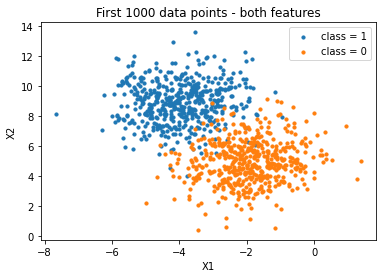

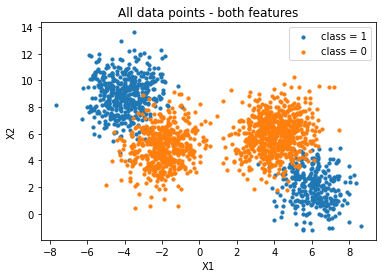

In [ ]:
plt.scatter(class_data_1_first1000[:, 0], class_data_1_first1000[:, 1], label="class = 1", s=10)
plt.scatter(class_data_0_first1000[:, 0], class_data_0_first1000[:, 1], label="class = 0", s=10)
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='best')
plt.title("First 1000 data points - both features")
plt.show()

plt.scatter(class_data_1_all[:, 0], class_data_1_all[:, 1], label="class = 1", s=10)
plt.scatter(class_data_0_all[:, 0], class_data_0_all[:, 1], label="class = 0", s=10)
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='best')
plt.title("All data points - both features")
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [ ]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta_vector = None
        self.J_history = []

    def compute_cost(self, X, y, theta):
        power = np.dot(X, theta) * (-1)
        dominator = 1 + (np.exp(power))
        hypothesis = 1 / dominator
        cost = ( np.log(hypothesis) * y * (-1) - (1 - y) * np.log(1 - hypothesis) ).mean()
     
        return cost

    def bias(self,X):
        temp = np.ones(X.shape[0])
        return np.column_stack((temp, X))

        return J

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        np.random.seed(self.random_state)
        X_bias = self.bias(X)
        theta = np.random.random(size=X_bias.shape[1])
        index = 0
  
        current_cost = self.compute_cost(X_bias, y, theta)
        
        improvment = current_cost
        self.J_history.append(current_cost)

        while index < self.n_iter and improvment >= self.eps:
            previous_cost = current_cost
            power = np.dot(X_bias, theta) * (-1)
            dominator = 1 + (np.exp(power))
            hypothesis = 1 / dominator
            loss = hypothesis - y
            gradient = np.dot(np.transpose(X_bias), loss) / y.size
         
            theta = theta - self.eta * gradient
            
            current_cost = self.compute_cost(X_bias, y, theta)
            self.J_history.append(current_cost)
            index +=1
            improvment = abs(current_cost - previous_cost)

        self.theta_vector = theta
    
    def predict(self, X):
        """Return the predicted class label"""
        predictions = []

        for i in range(len(X)):
            X_bias = np.insert(X[i],0,1)
            power = np.dot(X_bias, self.theta_vector) * (-1)
            dominator = 1 + (np.exp(power))
            hypothesis = 1 / dominator
            predictions.append(1 if hypothesis > 0.5 else 0)

        return np.asarray(predictions)
       

    def calc_accuracy(self, pred, labels):
        count = 0
        for i in range(len(pred)):
            if pred[i] == labels[i]: 
                count += 1

        return count / len(labels)        

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [ ]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]


training_set_numpy = training_set.to_numpy()
training_set_numpy_copy = training_set_numpy.copy()
np.random.shuffle(training_set_numpy_copy)

X_train_shuffled, y_train_shuffled = training_set_numpy_copy[:, [0,1]], training_set_numpy_copy[:, -1]


tuples_list = [(et,ep) for et in etas for ep in epss]
max_accuracy = -1
best_pair = tuples_list[0]


for index in range(5):
  for pair in tuples_list:
    data = LogisticRegressionGD(eta=pair[0], eps=pair[1])

    X_train = np.concatenate((X_train_shuffled[0:index * (X_train_shuffled.shape[0] // 5)], X_train_shuffled[(index + 1) * (X_train_shuffled.shape[0] // 5):]))
    y_train = np.concatenate((y_train_shuffled[0:index * (y_train_shuffled.shape[0] // 5)], y_train_shuffled[(index + 1) * (y_train_shuffled.shape[0] // 5):]))

    X_tester = X_train_shuffled[index * (X_train_shuffled.shape[0] // 5):(index + 1) * (X_train_shuffled.shape[0] // 5)]
    y_tester = y_train_shuffled[index * (y_train_shuffled.shape[0] // 5):(index + 1) * (y_train_shuffled.shape[0] // 5)]

    data.fit(X_train, y_train)

    
    accuracy = data.calc_accuracy(data.predict(X_tester), y_tester)
    if accuracy > max_accuracy:
      max_accuracy = accuracy
      best_pair = pair

best_eps = best_pair[1]
best_eta = best_pair[0]




## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [ ]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    power = (-1) * ((data - mu)**2) / (2*(sigma**2))
    return (1 / pow((2 * np.pi * (sigma**2)), (1/2))) * np.exp(power)

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [ ]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.w = np.array([])
        self.mu = np.array([])
        self.sigma = np.array([])
        self.random_state = random_state
        
    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        split_data = np.split(data, self.k)
        for index in range(self.k):
          self.w = np.append(self.w, 1/self.k)
          self.mu = np.append(self.mu, np.mean(split_data[index]))
          self.sigma = np.append(self.sigma, np.std(split_data[index]))
        

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """ 
        self.responsibilities = np.zeros(shape=(len(data), self.k))
        for index in range(self.k):
          self.responsibilities[:, index] = self.w[index] * norm_pdf(data, self.mu[index], self.sigma[index])
       
        sum_responsibilities = np.sum(self.responsibilities, axis=1)
        self.responsibilities = (self.responsibilities.T / sum_responsibilities.T).T
        

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        # for index in range(self.k):
        #   self.w[index] = np.sum(self.responsibilities) / data.shape[0]
        self.w = self.responsibilities.sum(axis=0) / data.shape[0]
    
        for index in range(self.k):
          alpha = 1 / (self.w[index] * data.shape[0])
          
          self.mu[index] = alpha * np.sum(np.dot(self.responsibilities[:, index], data))
          self.sigma[index] = np.sqrt(alpha * np.sum(np.dot(self.responsibilities[:, index], (data - self.mu[index])**2))) 


    def compute_cost(self, data):
        cost = []
        for index in range(self.k):
          cost.append(np.sum((-1) * np.log2(self.w[index] * norm_pdf(data, self.mu[index], self.sigma[index]))))

        return sum(cost)
      

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        previous_cost = float('inf')
        
        for iter in range(self.n_iter):
          self.expectation(data)
          self.maximization(data)
          
          current_cost = self.compute_cost(data)
          if abs(current_cost - previous_cost) < self.eps:
            break
          previous_cost = current_cost

    def get_dist_params(self):
        return self.mu, self.sigma
    

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [ ]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, random_state=1):
        self.k = k
        self.random_state = random_state
        self.labels = []
        self.mu = np.array([])
        self.sigma = np.array([])
        self.prior = 1/self.k

    def get_posterior(self, X):
        post = []
        for index in range(self.k):
          likelihood = np.prod(norm_pdf(X, self.mu[index], self.sigma[index]))
          post.append(likelihood * self.prior)
        
        return post

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """

        self.labels = [y[(len(X)//self.k)*i] for i in range(self.k)]
        self.mu = np.zeros(shape=(self.k,X.shape[1]))
        self.sigma = np.zeros(shape=(self.k, X.shape[1]))

        for feature in range(X.shape[1]):
          column_data = X[:, feature]
          learn_em = EM(k=self.k, random_state=self.random_state)
          learn_em.fit(column_data)
          column_data_mu, column_data_sigma = learn_em.get_dist_params()
          for index in range(self.k):
                self.mu[index][feature]=column_data_mu[index]
                self.sigma[index][feature]=column_data_sigma[index]
          

    def predict(self, X):
        """Return the predicted class label"""
        predictions = []
        for instance in X:
            cur_preds = self.get_posterior(instance)
            max_pred = self.labels[np.argmax(cur_preds)]
            predictions.append(max_pred)

        return np.asarray(predictions)

    def calc_accuracy(self, pred, labels):
        count = 0
        for i in range(len(pred)):
            if pred[i] == labels[i]: 
                count += 1

        return count / len(labels)



## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

logistic regression accuracy for First 1000 training points is: 0.965
logistic regression accuracy for First 1000 test points is: 0.94
Naive Bayes accuracy for First 1000 training points is: 0.963
Naive Bayes accuracy for First 1000 test points is: 0.926


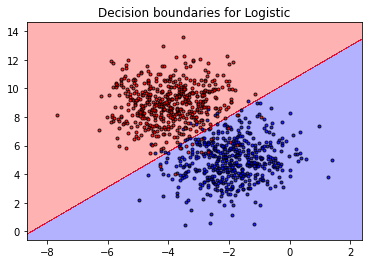

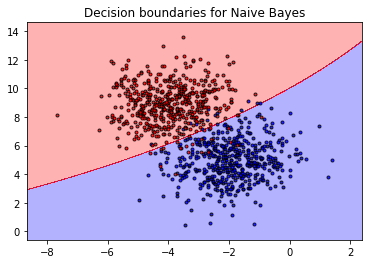

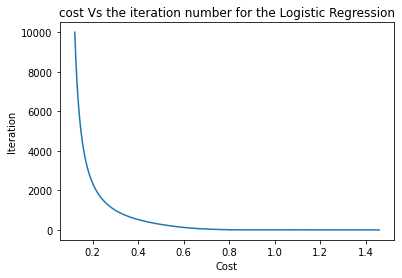

logistic regression accuracy for all training points is: 0.796
logistic regression accuracy for all test points is: 0.747
Naive Bayes accuracy for all training points is: 0.8335
Naive Bayes accuracy for all test points is: 0.798


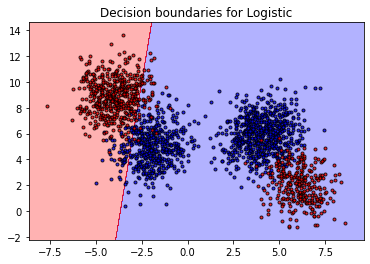

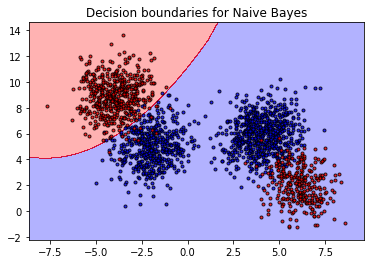

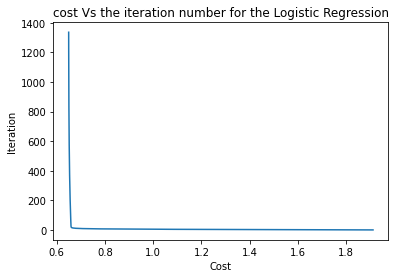

In [ ]:

#################################################################################
# first 1000

first_train_points = X_training[:1000]
first_y_points_train = y_training[:1000]

first_test_points = X_test[:500]
first_y_points_test = y_test[:500]



logistic_train = LogisticRegressionGD(eps=best_eps, eta=best_eta)
logistic_test = LogisticRegressionGD(eps=best_eps, eta=best_eta)

logistic_train.fit(first_train_points, first_y_points_train)
logistic_test.fit(first_test_points, first_y_points_test)

naive_train = NaiveBayesGaussian(k=4)
naive_test = NaiveBayesGaussian(k=4)

naive_train.fit(first_train_points, first_y_points_train)
naive_test.fit(first_test_points, first_y_points_test)

logistic_train_acc = logistic_train.calc_accuracy(logistic_train.predict(first_train_points), first_y_points_train)
logistic_test_acc = logistic_test.calc_accuracy(logistic_test.predict(first_test_points), first_y_points_test)

naive_train_acc = naive_train.calc_accuracy(naive_train.predict(first_train_points), first_y_points_train)
naive_test_acc = naive_test.calc_accuracy(naive_test.predict(first_test_points), first_y_points_test)

print(f'logistic regression accuracy for First 1000 training points is: {logistic_train_acc}')
print(f'logistic regression accuracy for First 1000 test points is: {logistic_test_acc}')
print(f'Naive Bayes accuracy for First 1000 training points is: {naive_train_acc}')
print(f'Naive Bayes accuracy for First 1000 test points is: {naive_test_acc}')


plt.figure()
plt.title("Decision boundaries for Logistic")
plot_decision_regions(first_train_points, first_y_points_train, logistic_train)
plt.show()

plt.figure()
plt.title("Decision boundaries for Naive Bayes")
plot_decision_regions(first_train_points, first_y_points_train, naive_train)
plt.show()

plt.figure()
plt.title("cost Vs the iteration number for the Logistic Regression")
plt.plot(logistic_train.J_history, range(len(logistic_train.J_history)))
plt.xlabel("Cost")
plt.ylabel("Iteration")
plt.show()

#################################################################################
# all points

logistic_train = LogisticRegressionGD(eps=best_eps, eta=best_eta)
logistic_test = LogisticRegressionGD(eps=best_eps, eta=best_eta)

logistic_train.fit(X_training, y_training)
logistic_test.fit(X_test, y_test)

naive_train = NaiveBayesGaussian(k=4)
naive_test = NaiveBayesGaussian(k=4)

naive_train.fit(X_training, y_training)
naive_test.fit(X_test, y_test)

logistic_train_acc = logistic_train.calc_accuracy(logistic_train.predict(X_training), y_training)
logistic_test_acc = logistic_test.calc_accuracy(logistic_test.predict(X_test), y_test)

naive_train_acc = naive_train.calc_accuracy(naive_train.predict(X_training), y_training)
naive_test_acc = naive_test.calc_accuracy(naive_test.predict(X_test), y_test)

print(f'logistic regression accuracy for all training points is: {logistic_train_acc}')
print(f'logistic regression accuracy for all test points is: {logistic_test_acc}')
print(f'Naive Bayes accuracy for all training points is: {naive_train_acc}')
print(f'Naive Bayes accuracy for all test points is: {naive_test_acc}')


plt.figure()
plt.title("Decision boundaries for Logistic")
plot_decision_regions(X_training, y_training, logistic_train)
plt.show()

plt.figure()
plt.title("Decision boundaries for Naive Bayes")
plot_decision_regions(X_training, y_training, naive_train)
plt.show()

plt.figure()
plt.title("cost Vs the iteration number for the Logistic Regression")
plt.plot(logistic_train.J_history, range(len(logistic_train.J_history)))
plt.xlabel("Cost")
plt.ylabel("Iteration")
plt.show()




We can see in the "all data points" graphs that the data is divided into 4 sub-data groups which are divided into two groups. This is why the logistics algorithm (which is more affected by all groups) cannot make a linear line that defines the data well, while the Naive-base algorithm can make a more flexible separation and thus be more accurate.



## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


In [ ]:

data1 = 30 + 4 * np.random.randn(500, 2)
data2 = 6 + 4 *  np.random.randn(500, 2)
data1 = np.row_stack((data1, data2))
data1 = np.column_stack((data1, np.zeros(1000)))

data3 = 27 + 4 * np.random.randn(500, 2)
data4 = 5 + 4 * np.random.randn(500, 2)
data3 = np.row_stack((data3, data4))
data3 = np.column_stack((data3 , np.ones(1000)))

data_naive = np.row_stack((data1, data3))



train, labels = data_naive[:, 0:2], data_naive[:, -1]


logistic_train = LogisticRegressionGD(eps=best_eps, eta=best_eta)

logistic_train.fit(train, labels)

naive_train = NaiveBayesGaussian(k=4)

naive_train.fit(train, labels)

logistic_train_acc = logistic_train.calc_accuracy(logistic_train.predict(train), labels)

naive_train_acc = naive_train.calc_accuracy(naive_train.predict(train), labels)

print(f'logistic regression accuracy for all training points is: {logistic_train_acc}')
print(f'Naive Bayes accuracy for all training points is: {naive_train_acc}')




logistic regression accuracy for all training points is: 0.5
Naive Bayes accuracy for all training points is: 0.6275


We can see that in this dataset, we divided the data into 4 normally distributed sub-data groups which are divided into two close datas with classes 1 and 0, and another two close datas with classes 1 and 0 (see the graph at the end for clarification). So the logistics algorithm is affected by all groups and cannot make a linear line that defines the data well, while the Naive-base algorithm can make a more flexible separation.


In [ ]:

np.random.seed(1)
feature1 =  np.random.randn(500) 
feature2 =  np.random.randn(500)
labels = np.zeros(500)

data_log = np.column_stack((feature1, feature2))
data_log += 3
data_log = np.column_stack((data_log, labels))

feature1 =  np.random.randn(500) 
feature2 =  np.random.randn(500)
labels = np.ones(500)

data_log2 = np.column_stack((feature1, feature2))
data_log2 = np.column_stack((data_log2, labels))


data_log = np.row_stack((data_log, data_log2))

train, labels = data_log[:, 0:2], data_log[:, -1]


logistic_train = LogisticRegressionGD(eps=best_eps, eta=best_eta)

logistic_train.fit(train, labels)

naive_train = NaiveBayesGaussian(k=4)

naive_train.fit(train, labels)

logistic_train_acc = logistic_train.calc_accuracy(logistic_train.predict(train), labels)

naive_train_acc = naive_train.calc_accuracy(naive_train.predict(train), labels)

print(f'logistic regression accuracy for all training points is: {logistic_train_acc}')
print(f'Naive Bayes accuracy for all training points is: {naive_train_acc}')

logistic regression accuracy for all training points is: 0.98
Naive Bayes accuracy for all training points is: 0.961


We can see that in this dataset, Logistic Regression will work better than Naive Bayes using EM
This because the data is separated by two sub-data groups (that are normally distributed and only differentiated by the mean value).
So the linear line made by the logistic regression algorithm is more accurate.

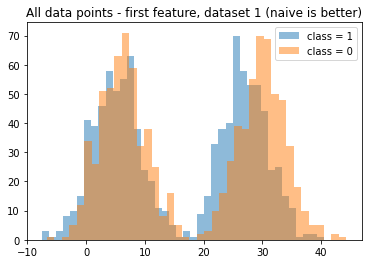

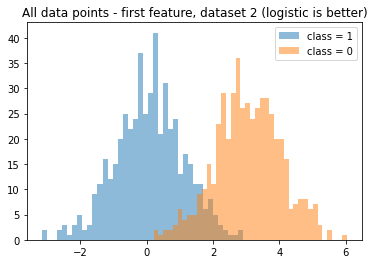

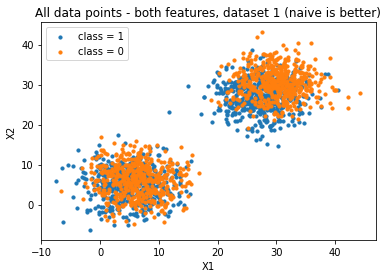

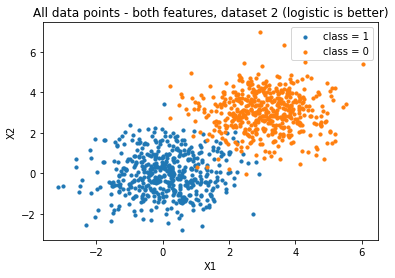

In [ ]:


class_data_1_naive = data_naive[np.where(data_naive[:, -1] == 1)]
class_data_0_naive = data_naive[np.where(data_naive[:, -1] == 0)]

class_data_1_log = data_log[np.where(data_log[:, -1] == 1)]
class_data_0_log = data_log[np.where(data_log[:, -1] == 0)]


plt.hist(class_data_1_naive[:,0], bins=40, alpha=0.5, label="class = 1")
plt.hist(class_data_0_naive[:,0], bins=40, alpha=0.5, label="class = 0")
plt.legend(loc='best')
plt.title("All data points - first feature, dataset 1 (naive is better)")
plt.show()

plt.hist(class_data_1_log[:,0], bins=40, alpha=0.5, label="class = 1")
plt.hist(class_data_0_log[:,0], bins=40, alpha=0.5, label="class = 0")
plt.legend(loc='best')
plt.title("All data points - first feature, dataset 2 (logistic is better)")
plt.show()


plt.scatter(class_data_1_naive[:, 0], class_data_1_naive[:, 1], label="class = 1", s=10)
plt.scatter(class_data_0_naive[:, 0], class_data_0_naive[:, 1], label="class = 0", s=10)
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='best')
plt.title("All data points - both features, dataset 1 (naive is better)")
plt.show()

plt.scatter(class_data_1_log[:, 0], class_data_1_log[:, 1], label="class = 1", s=10)
plt.scatter(class_data_0_log[:, 0], class_data_0_log[:, 1], label="class = 0", s=10)
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='best')
plt.title("All data points - both features, dataset 2 (logistic is better)")
plt.show()